In [1]:
# Importing libraries.
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from skimage import io

In [2]:
data_path = 'dataset'
categories = os.listdir(data_path)
labels = [i for i in range(len(categories))]
label_dict = dict(zip(categories, labels))
print(label_dict)

{'without_mask': 0, 'with_mask': 1}


In [3]:
img_size = (160, 160) #image size 
data = []
target = []

In [4]:

for category in categories: #without_mask and with_mask
  folder_path = os.path.join(data_path, category) #Getting the subfolder path
  img_names = os.listdir(folder_path) #Listing all items in that subfolder

  for img_name in img_names: #All the images in that subfolder
    img_path = os.path.join(folder_path, img_name) #Getting the image path
    img = io.imread(img_path) #Reading the image 
    #print(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #Converting from BGR to RGB

    try:
      resized = cv2.resize(img, img_size) #Image resizing

      data.append(resized)
      target.append(label_dict[category])

    except Exception as e:
      print("Exception: ", e)

In [5]:
data = np.array(data)/255.0 #Rescaling
data = np.reshape(data, (data.shape[0], img_size[0], img_size[1], 3)) #Reshaping 
target = np.array(target)
target = to_categorical(target)


In [6]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size = 0.2, shuffle = True)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5, shuffle = True)

In [7]:
datagen = ImageDataGenerator( # Data Augmentation
        rotation_range=15,
        zoom_range = 0.15,  
        width_shift_range=0.1, 
        height_shift_range=0.1)

In [23]:
imgs_ = datagen.flow_from_directory("dataset/",
                                     batch_size = 5,
                                     target_size=(150, 150),
                                     class_mode= 'binary'
                                    )

Found 3833 images belonging to 2 classes.


In [8]:
vgg = VGG16(input_shape = (160, 160, 3), weights = 'imagenet', include_top = False)


In [9]:
for layer in vgg.layers: # Setting all VGG16 layers false for training.
  layer.trainable = False

In [10]:
x = Flatten()(vgg.output)

prediction = Dense(units = 2, activation = 'softmax')(Dense(units = 64, activation = 'relu')(x)) # Adding dense layer

model = Model(inputs = vgg.input, outputs = prediction) # Joining the pre-training convolutional layers and dense layers

print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 160, 160, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 160, 160, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 80, 80, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 80, 80, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 80, 80, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 40, 40, 128)       0     

In [11]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])


In [12]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),  epochs=11, validation_data = (X_val, y_val))


Epoch 1/11
96/96 [==============================] - 153s 2s/step - loss: 0.2638 - accuracy: 0.8878 - val_loss: 0.0649 - val_accuracy: 0.9791
Epoch 2/11
96/96 [==============================] - 162s 2s/step - loss: 0.0827 - accuracy: 0.9720 - val_loss: 0.0489 - val_accuracy: 0.9843
Epoch 3/11
96/96 [==============================] - 169s 2s/step - loss: 0.0681 - accuracy: 0.9772 - val_loss: 0.0325 - val_accuracy: 0.9869
Epoch 4/11
96/96 [==============================] - 197s 2s/step - loss: 0.0532 - accuracy: 0.9843 - val_loss: 0.0475 - val_accuracy: 0.9843
Epoch 5/11
96/96 [==============================] - 159s 2s/step - loss: 0.0299 - accuracy: 0.9918 - val_loss: 0.0275 - val_accuracy: 0.9869
Epoch 6/11
96/96 [==============================] - 157s 2s/step - loss: 0.0338 - accuracy: 0.9853 - val_loss: 0.0214 - val_accuracy: 0.9896
Epoch 7/11
96/96 [==============================] - 160s 2s/step - loss: 0.0349 - accuracy: 0.9879 - val_loss: 0.0190 - val_accuracy: 0.9948
Epoch 8/11
96

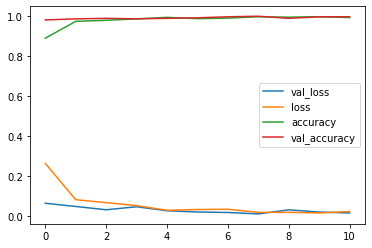

In [16]:
plt.plot(np.arange(0, 11), history.history['val_loss'], label='val_loss')
plt.plot(np.arange(0, 11), history.history['loss'], label = 'loss')
plt.plot(np.arange(0, 11), history.history['accuracy'], label = 'accuracy')
plt.plot(np.arange(0, 11), history.history['val_accuracy'], label = 'val_accuracy')
plt.legend()
plt.show()


In [25]:
model.save("maskclassifier.model", save_format = "h5")